# Analyse des données NHANES (Étude Diabète, Âge, IMC)

## Introduction
Ce notebook présente une analyse des données du **National Health and Nutrition Examination Survey (NHANES)**, cycle 2017-2018 (J).

L'objectif est d'explorer les relations entre :
- **L'Indice de Masse Corporelle (IMC)**
- **L'Âge**
- **Le Statut Diabétique**


## 1. Installation et Chargement des Bibliothèques
Nous augmentons le délai de téléchargement pour éviter les échecs de connexion et installons les dépendances critiques comme `stringi`.

In [9]:
# Augmenter le temps de téléchargement (évite les timeouts)
options(timeout = 300)

# Liste des packages nécessaires
packages <- c("haven", "dplyr", "janitor", "ggplot2", "stringi", "knitr")

# Installation des packages manquants
new_packages <- packages[!(packages %in% installed.packages()[,"Package"])]
if(length(new_packages)) install.packages(new_packages, dependencies = TRUE)

# Chargement
library(haven)
library(dplyr)
#library(janitor)
library(ggplot2)
library(knitr)

Warning message:
"package 'knitr' was built under R version 4.5.2"


## 2. Chargement des données NHANES
Chargement des modules Démographie, Anthropométrie, Questionnaire Diabète et Glycémie.

In [10]:
demo <- read_xpt("Data/DEMO_J.xpt")
bmx  <- read_xpt("Data/BMX_J.xpt")  
diq  <- read_xpt("Data/DIQ_J.xpt")  
glu  <- read_xpt("Data/GLU_J.xpt")  

## 3. Fusion et Inspection
Fusion des modules NHANES à l’aide de l’identifiant `seqn`. Nous utilisons des noms en minuscules suite au nettoyage précédent.

In [11]:
df <- demo %>%
  left_join(bmx, by = "SEQN") %>%
  left_join(diq, by = "SEQN") %>%
  left_join(glu, by = "SEQN")

# Dimensions après fusion
dim(df)

# Vérifier l'absence de doublons
anyDuplicated(df$SEQN)

# Aperçu des valeurs manquantes pour les variables clés
colSums(is.na(df[, c("RIDAGEYR", "RIAGENDR", "BMXBMI", "DIQ010", "LBXGLU")]
))

[1] 9254  122

[1] 0

RIDAGEYR RIAGENDR   BMXBMI   DIQ010   LBXGLU 
       0        0     1249      357     6363

## 4. Nettoyage et Recodage
Simplification des noms et création de variables binaires pour le modèle.

In [12]:
df_clean <- df %>%
  select(
    SEQN,
    age = RIDAGEYR,
    sex = RIAGENDR,
    bmi = BMXBMI,
    diabetes = DIQ010,
    glucose = LBXGLU
  ) %>%
  mutate(
    diabetes_bin = case_when(
      diabetes == 1 ~ 1,
      diabetes == 2 ~ 0,
      TRUE ~ NA_real_
    ),
    sex = case_when(
      sex == 1 ~ "Male",
      sex == 2 ~ "Female",
      TRUE ~ NA_character_
    )
  )

head(df_clean)


SEQN,age,sex,bmi,diabetes,glucose,diabetes_bin
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
93703,2,Female,17.5,2,NA,0
93704,2,Male,15.7,2,NA,0
93705,66,Female,31.7,2,NA,0
93706,18,Male,21.5,2,NA,0
93707,13,Male,18.1,2,NA,0
93708,66,Female,23.7,3,122,NA


In [13]:
# Distribution par sexe
df_clean %>%
  count(sex) %>%
  mutate(pourcentage = round(n / sum(n) * 100, 1)) %>%
  kable(col.names = c("Sexe", "Effectif", "Proportion (%)"))



|Sexe   | Effectif| Proportion (%)|
|:------|--------:|--------------:|
|Female |     4697|           50.8|
|Male   |     4557|           49.2|

In [14]:
# Statistiques de l'âge
age_stats <- data.frame(
  Statistique = c("Minimum", "1er quartile", "Médiane", "Moyenne", "3e quartile", "Maximum"),
  Valeur = round(as.numeric(summary(df_clean$age)), 1)
)

knitr::kable(age_stats, caption = "Résumé statistique de l'âge")




Table: Résumé statistique de l'âge

|Statistique  | Valeur|
|:------------|------:|
|Minimum      |    0.0|
|1er quartile |   11.0|
|Médiane      |   31.0|
|Moyenne      |   34.3|
|3e quartile  |   58.0|
|Maximum      |   80.0|

## 5. Analyses Descriptives
Résumé statistique de l'âge, de l'IMC et du nombre de cas de diabète.

In [15]:
# Résumé statistique de l'âge
summary(df_clean$age)

# Résumé statistique de l'IMC
summary(df_clean$bmi)

# Répartition du diabète (binaire)
table(df_clean$diabetes_bin)
prop.table(table(df_clean$diabetes_bin))


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   11.00   31.00   34.33   58.00   80.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  12.30   20.40   25.80   26.58   31.30   86.20    1249 


   0    1 
7816  893 


        0         1 
0.8974624 0.1025376 

## 6. Visualisations
Impact de l'IMC sur le statut diabétique.

Warning message:
"Removed 1249 rows containing non-finite outside the scale range (`stat_bin()`)."


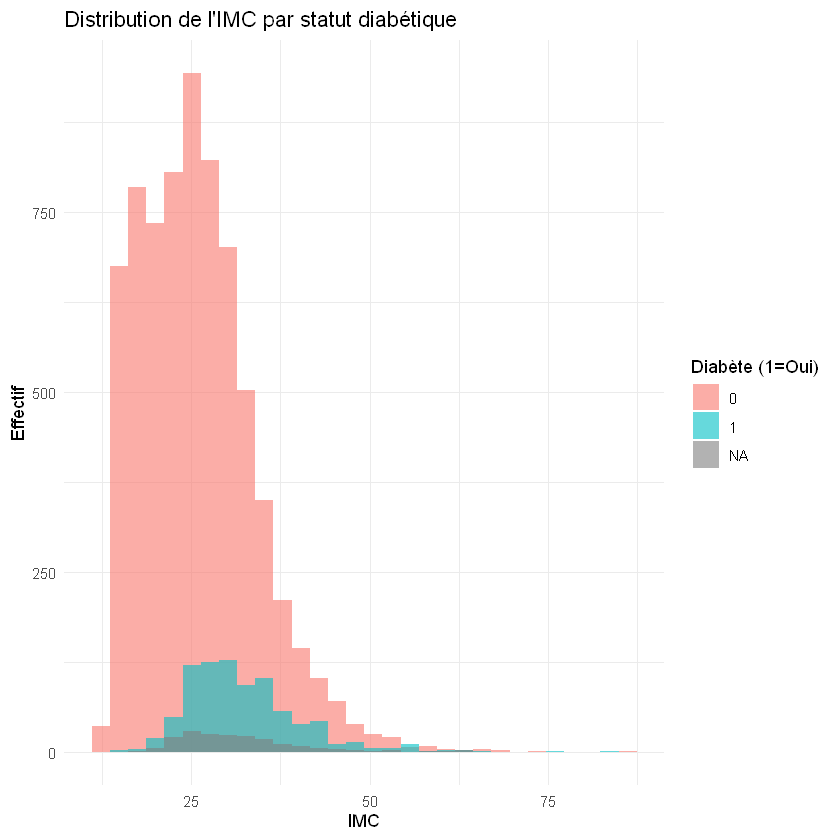

In [16]:
ggplot(df_clean, aes(x = bmi, fill = factor(diabetes_bin))) +
  geom_histogram(alpha = 0.6, bins = 30, position = "identity") +
  labs(
    title = "Distribution de l'IMC par statut diabétique",
    x = "IMC",
    y = "Effectif",
    fill = "Diabète (1=Oui)"
  ) +
  theme_minimal()

Nous allons commencer par visualiser la distribution de l'IMC entre les personnes diabétiques et non diabétiques à l'aide d'un Histogramme. Cela nous permet de voir les différences dans la répartition de l'IMC entre ces deux groupes.

Warning message:
"Removed 881 rows containing non-finite outside the scale range (`stat_bin()`)."


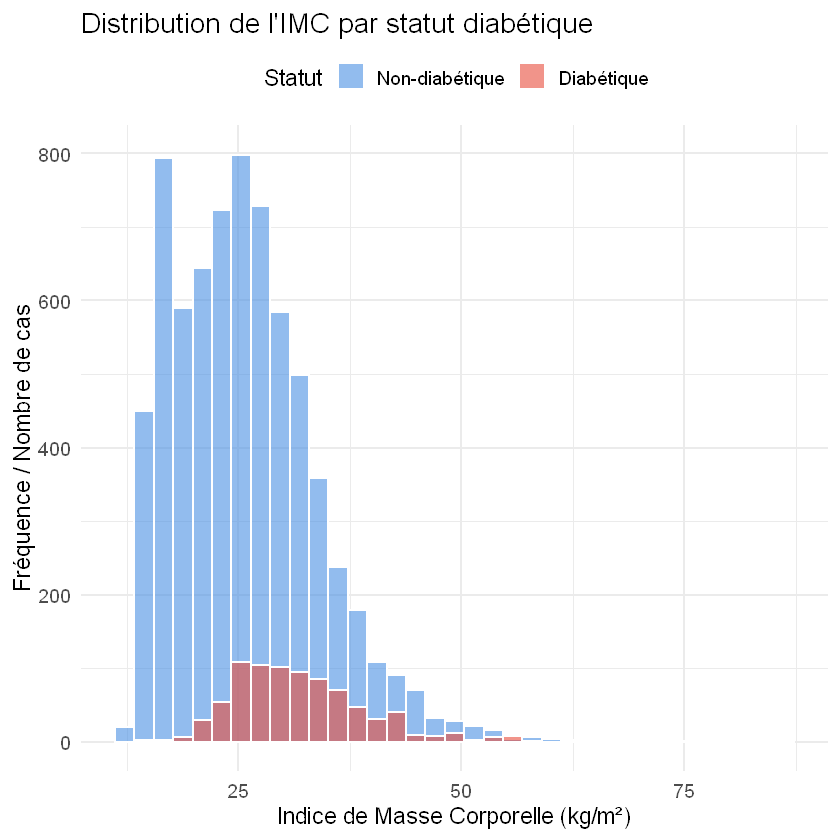

In [23]:
# Histogramme de l'IMC par statut diabétique
ggplot(df_clean %>% filter(!is.na(diabetes_bin)), aes(x = bmi, fill = factor(diabetes_bin))) +
  geom_histogram(alpha = 0.6, bins = 35, position = "identity", color = "white") +
  scale_fill_manual(
    values = c("1" = "#e74c3c", "0" = "#4a90e2"),
    labels = c("1" = "Diabétique", "0" = "Non-diabétique")
  ) +
  labs(
    title = "Distribution de l'IMC par statut diabétique",
    x = "Indice de Masse Corporelle (kg/m²)",
    y = "Fréquence / Nombre de cas",
    fill = "Statut"
  ) +
  theme_minimal(base_size = 14) +
  theme(legend.position = "top")


Histogramme : L'histogramme montre une distribution plus élevée de l'IMC chez les diabétiques (en rouge) par rapport aux non-diabétiques (en bleu). Cela confirme que les personnes atteintes de diabète ont tendance à avoir un IMC plus élevé, ce qui est un facteur de risque bien connu pour le diabète de type 2.

Ensuite, nous allons utiliser un boxplot pour comparer la répartition de l'âge chez les diabétiques et non-diabétiques. Cela permet de mieux visualiser la médiane, l'écart interquartile et les valeurs aberrantes.

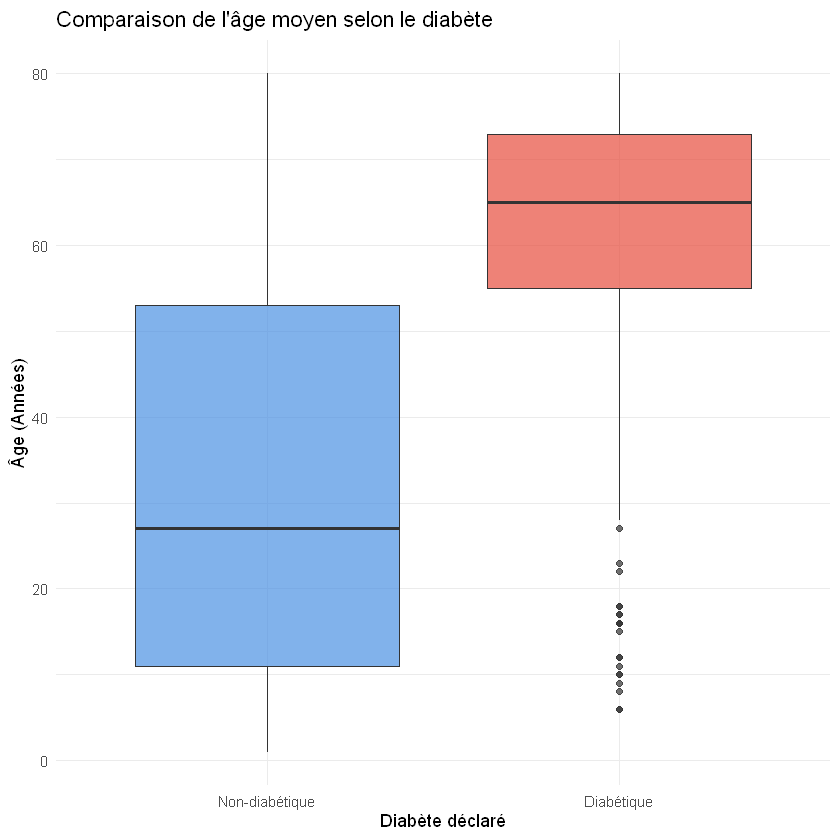

In [17]:
# Boxplot de l'âge selon le statut diabétique
ggplot(df_clean %>% filter(!is.na(diabetes_bin)), aes(x = factor(diabetes_bin), y = age, fill = factor(diabetes_bin))) +
  geom_boxplot(alpha = 0.7) +
  scale_fill_manual(
    values = c("1" = "#e74c3c", "0" = "#4a90e2"),
    labels = c("1" = "Diabétique", "0" = "Non-diabétique")
  ) +
  scale_x_discrete(labels = c("0" = "Non-diabétique", "1" = "Diabétique")) +
  labs(
    title = "Comparaison de l'âge moyen selon le diabète",
    x = "Diabète déclaré",
    y = "Âge (Années)"
  ) +
  theme_minimal() +
  guides(fill = "none")


Boxplot : Le boxplot montre que les diabétiques ont un âge médian plus élevé par rapport aux non-diabétiques. Les individus diabétiques sont concentrés dans les tranches d'âge plus âgées, ce qui suggère que le diabète est plus courant à mesure que l'on vieillit.

Il est aussi intéressant de voir si l'IMC et l'âge sont corrélés. Un nuage de points avec une ligne de tendance peut nous aider à visualiser cette relation

`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 1249 rows containing non-finite outside the scale range
(`stat_smooth()`)."
Warning message:
"Removed 1249 rows containing missing values or values outside the scale range
(`geom_point()`)."


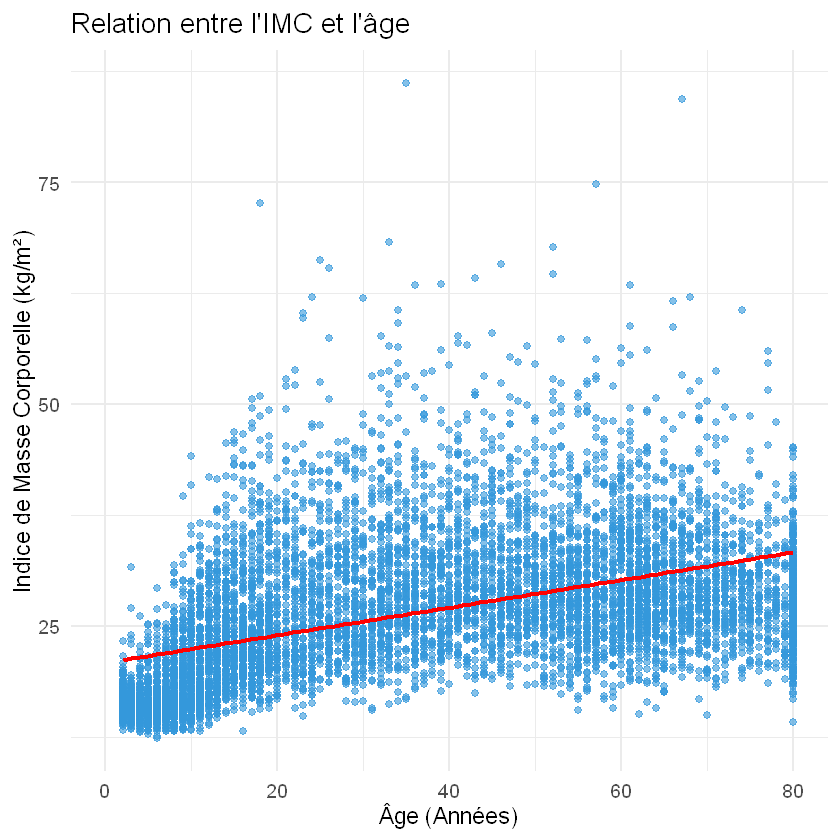

In [18]:
# Nuage de points entre IMC et âge avec une ligne de tendance
ggplot(df_clean, aes(x = age, y = bmi)) +
  geom_point(alpha = 0.6, color = "#3498db") +
  geom_smooth(method = "lm", color = "red", se = FALSE) +
  labs(
    title = "Relation entre l'IMC et l'âge",
    x = "Âge (Années)",
    y = "Indice de Masse Corporelle (kg/m²)"
  ) +
  theme_minimal(base_size = 14)


Nuage de points : Le nuage de points avec une ligne de régression montre une relation positive entre l'âge et l'IMC. Autrement dit, à mesure que l'on vieillit, l'IMC tend à augmenter, ce qui est attendu puisque le métabolisme ralentit avec l'âge, entraînant souvent une prise de poids.

Pour mieux comprendre la distribution du sexe entre les groupes diabétiques et non-diabétiques, nous allons utiliser un diagramme à barres.

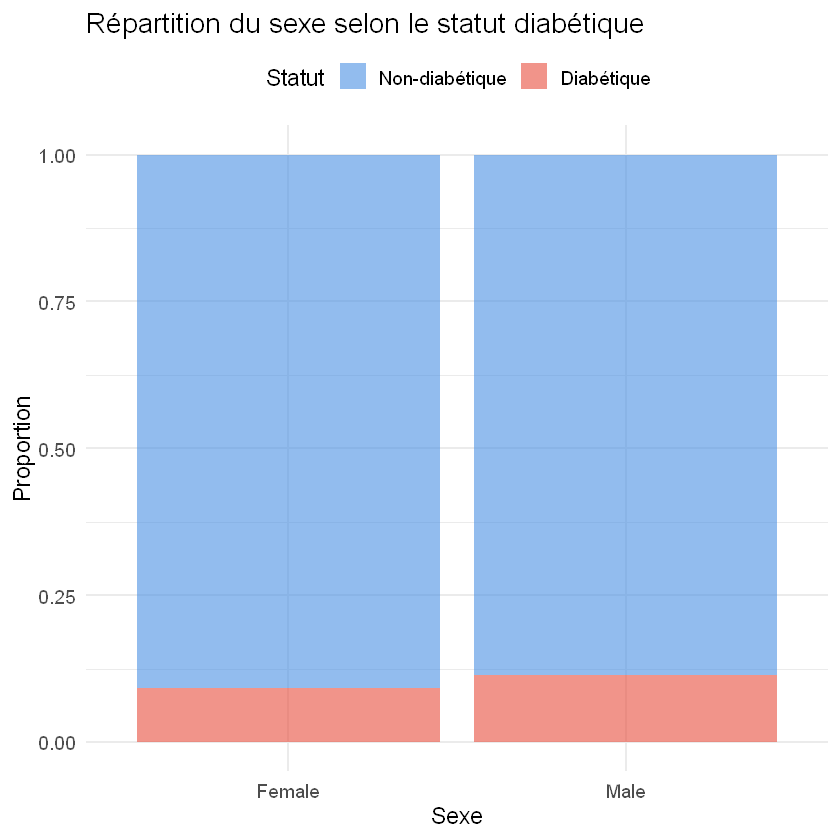

In [22]:
# Diagramme à barres du sexe selon le statut diabétique
ggplot(df_clean %>% filter(!is.na(diabetes_bin)), aes(x = sex, fill = factor(diabetes_bin))) +
  geom_bar(position = "fill", alpha = 0.6) +
  scale_fill_manual(
    values = c("1" = "#e74c3c", "0" = "#4a90e2"),
    labels = c("1" = "Diabétique", "0" = "Non-diabétique")
  ) +
  labs(
    title = "Répartition du sexe selon le statut diabétique",
    x = "Sexe",
    y = "Proportion",
    fill = "Statut"
  ) +
  theme_minimal(base_size = 14) +
  theme(legend.position = "top")

Diagramme à barres : Le graphique montre la répartition des sexes parmi les diabétiques et non-diabétiques. On peut observer que les hommes ont une proportion plus élevée de diabète par rapport aux femmes dans cet échantillon, ce qui est cohérent avec les études épidémiologiques indiquant un risque accru de diabète chez les hommes.

Une autre façon d'analyser les données est de diviser la population en tranches d'âge et de calculer la proportion de diabétiques et non diabétiques dans chaque tranche. Cela peut être réalisé par un graphique à barres empilées.

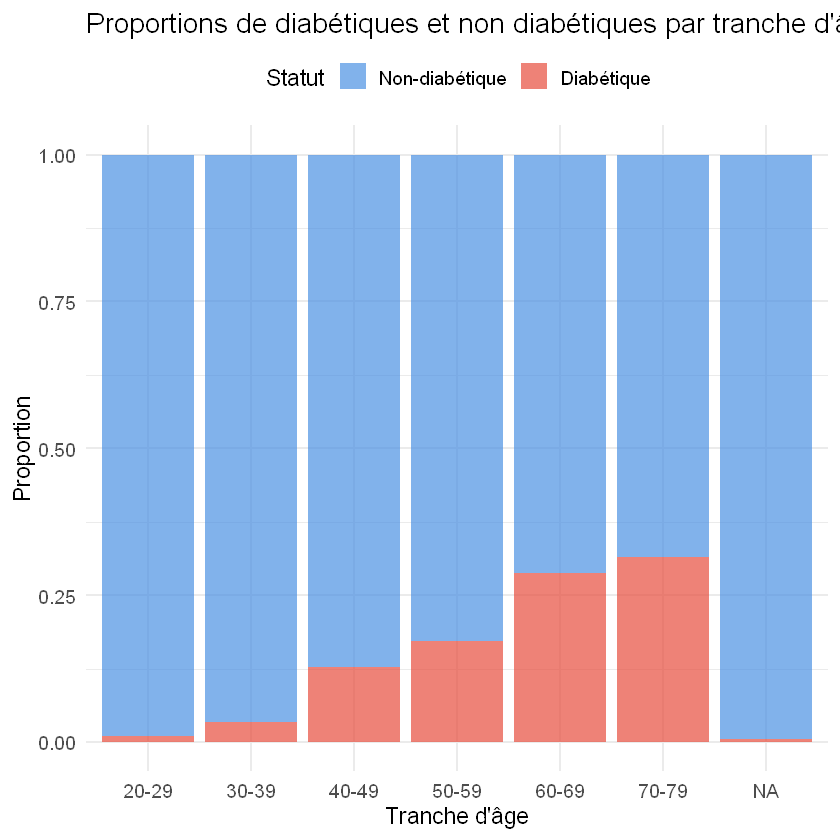

In [20]:
# Création des tranches d'âge
df_clean$age_group <- cut(df_clean$age, breaks = c(20, 30, 40, 50, 60, 70, 80, 90, 100), 
                          labels = c("20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80-89", "90+"))

# Diagramme à barres empilées
ggplot(df_clean %>% filter(!is.na(diabetes_bin)), aes(x = age_group, fill = factor(diabetes_bin))) +
  geom_bar(position = "fill", alpha = 0.7) +
  scale_fill_manual(
    values = c("1" = "#e74c3c", "0" = "#4a90e2"),
    labels = c("1" = "Diabétique", "0" = "Non-diabétique")
  ) +
  labs(
    title = "Proportions de diabétiques et non diabétiques par tranche d'âge",
    x = "Tranche d'âge",
    y = "Proportion",
    fill = "Statut"
  ) +
  theme_minimal(base_size = 14) +
  theme(legend.position = "top")


Graphique à barres empilées : Ce graphique nous montre comment le diabète est réparti par tranche d'âge. On peut voir que la proportion de diabétiques augmente dans les tranches d'âge plus âgées, ce qui est une tendance bien connue dans les études épidémiologiques.

Conclusion des visualisations

Ces visualisations renforcent les conclusions générales de l'analyse des données :

IMC et diabète : Les individus diabétiques ont en moyenne un IMC plus élevé que les non-diabétiques.

Âge et diabète : L'incidence du diabète augmente avec l'âge, ce qui souligne l'importance de surveiller la santé métabolique avec l'âge.

Sexe et diabète : Les hommes ont un risque plus élevé de diabète dans cet échantillon.

Tranches d'âge : Les diabétiques sont plus nombreux dans les tranches d'âge plus avancées, ce qui est cohérent avec la notion que le diabète de type 2 est une maladie liée à l'âge et aux facteurs de risque cumulatifs.